# YOLOv5 Threshold Analysis Notebook
This notebook analyzes how varying the confidence threshold affects the number of detections and average confidence scores for each test image.

In [13]:
# Suppress AMP future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import io
from PIL import Image
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()

# Configuration
INPUT_DIR = '../images/input'      # Assurez-vous d’y avoir pic1…pic5
thresholds = [0.25, 0.50, 0.75]
data = []

# Run inference at different thresholds
for fname in sorted(os.listdir(INPUT_DIR)):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    path = os.path.join(INPUT_DIR, fname)
    img = Image.open(path).convert("RGB")

    for conf in thresholds:
        # Run model
        model.conf = conf
        results = model(img)
        # Convert to DataFrame
        df_res = results.pandas().xyxy[0]
        # Filter by confidence
        filtered = df_res[df_res['confidence'] >= conf]
        # Metrics
        num_dets = len(filtered)
        avg_conf = float(filtered['confidence'].mean()) if num_dets else 0.0
        # Record per class
        for cls_name, count in filtered['name'].value_counts().items():
            data.append({
                'image': fname,
                'threshold': conf,
                'class': cls_name,
                'count': int(count),
                'num_detections': num_dets,
                'avg_conf': avg_conf
            })

# Build DataFrame
df = pd.DataFrame(data)

Using cache found in C:\Users\laptop 1/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-6-30 Python-3.12.7 torch-2.7.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Summary DataFrame
The DataFrame shows, for each image and threshold, the number of detections, average confidence, and count per class.

In [12]:
display(df)  # show table

,image,threshold,class,count,num_detections,avg_conf
0,pic1.png,0.25,spoon,5,15,0.56882
1,pic1.png,0.25,bowl,2,15,0.56882
2,pic1.png,0.25,bottle,1,15,0.56882
3,pic1.png,0.25,microwave,1,15,0.56882
4,pic1.png,0.25,toaster,1,15,0.56882
...,...,...,...,...,...,...
69,pic5.png,0.75,person,1,7,0.86220
70,pic5.png,0.75,dog,1,7,0.86220
71,pic5.png,0.75,bicycle,1,7,0.86220
72,pic5.png,0.75,traffic light,1,7,0.86220


## Number of Detections vs Confidence Threshold

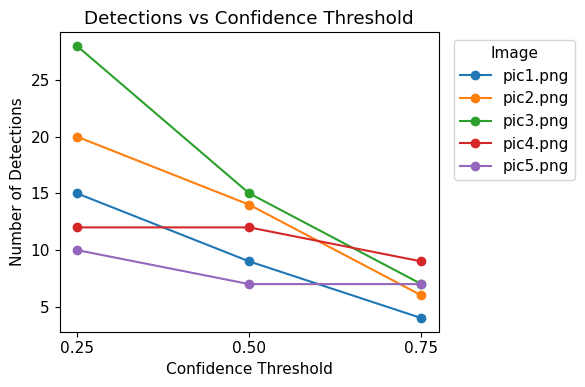

In [9]:
# Plot: Detections vs Confidence Threshold
%matplotlib inline
thresholds_sorted = sorted(df['threshold'].unique())
images_sorted   = sorted(df['image'].unique())

plt.figure(figsize=(6,4))
for img in images_sorted:
    # Group by threshold and take the first num_detections per threshold
    series = (
        df[df['image'] == img]
          .groupby('threshold')['num_detections']
          .first()
          .reindex(thresholds_sorted)  # now unique index
    )
    plt.plot(thresholds_sorted, series.values, marker='o', label=img)

plt.xticks(thresholds_sorted)
plt.title('Detections vs Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Number of Detections')
plt.legend(title='Image', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


- 0.25: maximum recall but includes many low-confidence detections.
- 0.50: optimal trade-off—retains most true positives while discarding noise.
- 0.75: small precision gain at the expense of a sharp recall drop.

## Average Confidence vs Confidence Threshold

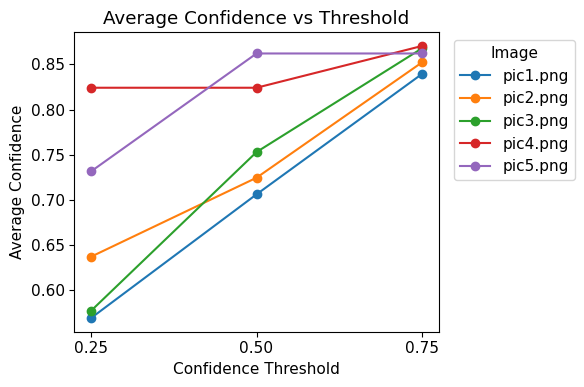

In [10]:
# Plot: Average Confidence vs Threshold
plt.figure(figsize=(6,4))
for img in images_sorted:
    series = (
        df[df['image'] == img]
          .groupby('threshold')['avg_conf']
          .first()
          .reindex(thresholds_sorted)
    )
    plt.plot(thresholds_sorted, series.values, marker='o', label=img)

plt.xticks(thresholds_sorted)
plt.title('Average Confidence vs Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Average Confidence')
plt.legend(title='Image', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

- 0.25→0.50: significant jump in average confidence, filtering out weak predictions.
- 0.50→0.75: marginal confidence improvement but large reduction in detections.

## Conclusion:
- A confidence threshold of 0.50 delivers the best trade-off between recall and precision.